In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as style
import matplotlib.dates as mdates
import plotly.graph_objs as go
import seaborn as sns
sns.set_style("darkgrid")
from ta.momentum import RSIIndicator
from ta.trend import MACD
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv("Official_Dataset.csv")

In [3]:
tickers = list(df["Ticker"].unique())
# print(tickers)

In [4]:
def stockSetup(df, ticker):
    '''the stock setup function cleans the dataframe and filters it according to a specific ticker you input'''
    if ticker in tickers:
        stockData = df[df["Ticker"]==ticker]
    else:
        raise Exception("Ticker is not valid")
  
    stockData = stockData.drop('Ticker', axis=1)
    stockData = stockData.drop("File", axis=1)
    stockData = stockData.round(2)
    stockData['Date'] = pd.to_datetime(stockData['Date'])
    stockData = stockData.set_index('Date')
    stockData.dropna(axis=0, inplace=True)
    return stockData


# these functions below convert the object oriented version of the TA library into functions that are easy to call
def generateRSI(df, period=14):
  return RSIIndicator(df["Adj Close"], period).rsi()

def generateMACD(df, periodShort=12, periodLong=26):
  return MACD(df["Adj Close"], n_slow=periodShort, n_fast=periodLong).macd()

def generateMACDSignal(df, period=9):
  return MACD(df["Adj Close"], n_sign=period).macd_signal()

def generateMACDDiff(df, periodShort=12, periodLong=26, periodSign=9):
  return MACD(df["Adj Close"], n_slow=periodShort, n_fast=periodLong, n_sign=periodSign).macd_diff()

def generatePercentageChange(df):
  return df["Adj Close"].pct_change()*100

In [5]:
figures = []
def plotAdjClose(df):
  figures.append(plt.figure(figsize=(15,8)))
  sns.lineplot(x = df.index, y=df['Adj Close'])
  plt.show()

def plotRSI(df, overBought=70, overSold=30, period=14):
  df["RSI"] = generateRSI(df, period)
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x = df.index, y=df['RSI'])
  plt.plot([df.index.min(),df.index.max()],[overBought, overBought])
  plt.plot([df.index.min(),df.index.max()],[overSold, overSold])
  plt.show()

def plotMACD(df, periodShort=12, periodLong=26, periodSignal=9):
  df['MACD'] = generateMACD(df, periodShort, periodLong)
  df["MACD Signal"] = generateMACDSignal(df, periodSignal)
  df['MACD Difference'] = generateMACDDiff(df, periodShort, periodLong, periodSignal)
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x = df.index, y=df['MACD'])
  sns.lineplot(x = df.index, y=df['MACD Signal'])
  plt.show()

def plotPercentageChange(df):
  df['Percentage Change'] = generatePercentageChange(df)
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x = df.index, y=df['Percentage Change'])
  plt.show()

def plotVolume(df):
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x=df.index, y=df['Volume'])



In [6]:
generatedData = stockSetup(df, "JNJ")
generatedData.head(-5)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2005-01-03,40.63,62.90,63.55,62.69,63.35,7859500.0
2005-01-04,40.50,62.70,63.24,62.62,63.10,6989600.0
2005-01-05,40.47,62.66,63.09,62.59,62.87,6888100.0
2005-01-06,40.59,62.84,63.09,62.69,62.75,5277500.0
2005-01-07,40.44,62.61,63.00,62.57,62.98,5037800.0
...,...,...,...,...,...,...
2019-12-17,142.65,143.56,144.05,142.52,143.00,10722400.0
2019-12-18,142.28,143.19,143.88,142.74,143.72,7849200.0
2019-12-19,144.43,145.35,145.88,143.61,143.89,9414700.0


In [7]:
#years = generatedData.index.year.unique() # Change this to be specific years you want to filter out
years = [2019]
filteredDf = generatedData[generatedData.index.year.isin(years)]

months = filteredDf.index.month.unique() # Change this to be specific months you want to filter out
#months = [#put your months here]
filteredDf = filteredDf[filteredDf.index.month.isin(months)]

days = filteredDf.index.day.unique() # Change this to be specific days you want to filter out
#days = [#put your days here]
filteredDf = filteredDf[filteredDf.index.day.isin(days)]



In [8]:
def createCandlestck(df): 
    data=[go.Candlestick(x=filteredDf.index,
                open=filteredDf['Open'],
                high=filteredDf['High'],
                low=filteredDf['Low'],
                close=filteredDf['Close'])]
    return go.Figure(data=data)

createCandlestck(df).show()

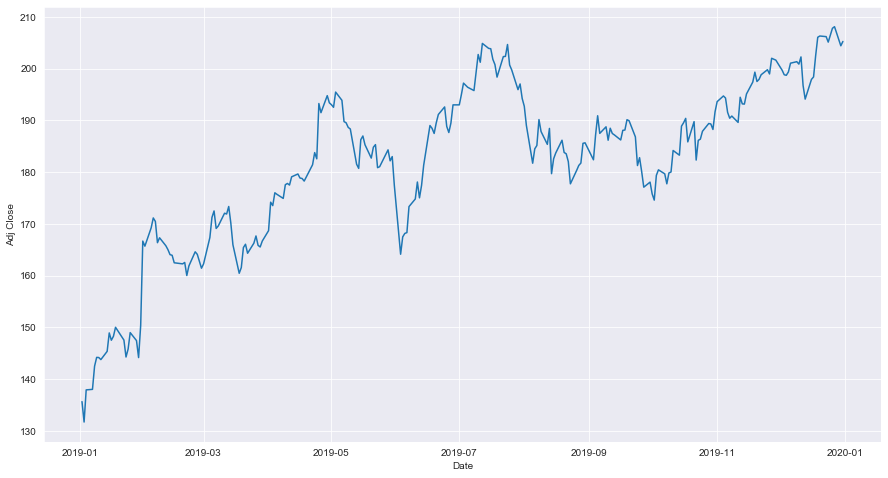

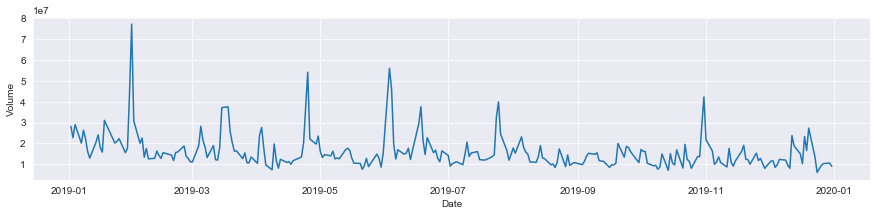

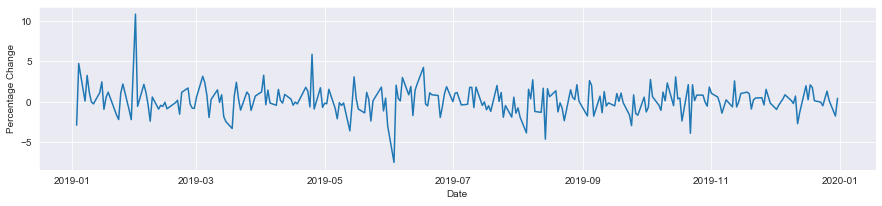

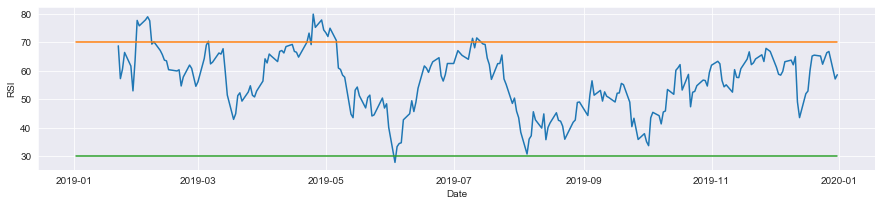

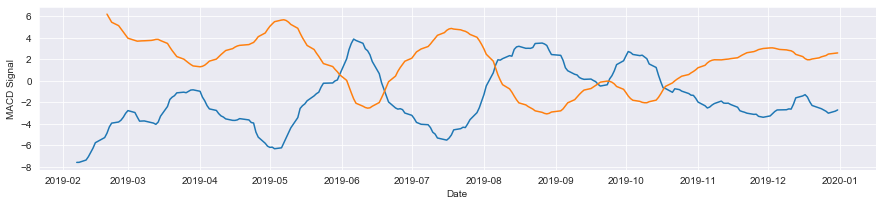

In [31]:
df2 = stockSetup(df, "FB")
df2 = df2[df2.index.year.isin([2019])]
plotAdjClose(df2)
plotVolume(df2)
plotPercentageChange(df2)
plotRSI(df2, overBought=70, overSold=30)
plotMACD(df2)

In [14]:
SmaWindow=7


newDf = stockSetup(df, 'JNJ')
newDf = newDf[newDf.index.year.isin([2019])]
newDf["RSI"] = generateRSI(newDf)
newDf["MACD"] = generateMACD(newDf)
newDf["SMA"] = newDf['Adj Close'].rolling(window=SmaWindow).mean()

fallingKniveDf = newDf[newDf["MACD"] <= -.5]
fallingKniveDf = newDf[newDf['Adj Close'] < newDf['SMA']]
fallingKniveDf = newDf[newDf['RSI'] <40]

21


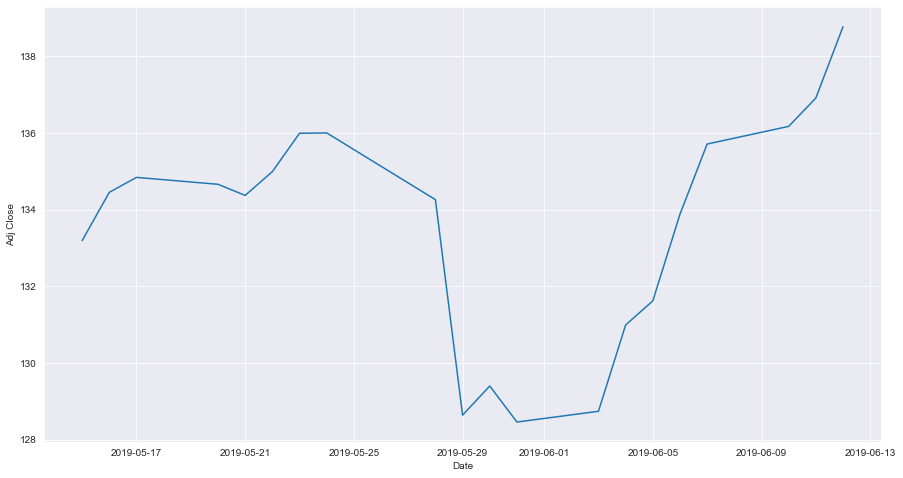

In [15]:
# takes the filtered df from cell above and graphs a specific interval around that date
aroundIndex = []
for date in fallingKniveDf.index:
    aroundIndex.append(pd.date_range(start=date - timedelta(weeks=2), end=date+ timedelta(weeks=2)))

FallingKnifeSubset = []
for dates in aroundIndex:
    FallingKnifeSubset.append(newDf[newDf.index.isin(dates)])
print(len(FallingKnifeSubset))
plotAdjClose(FallingKnifeSubset[0])

In [7]:
df = pd.read_csv("Official_Dataset.csv")

all_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
wikitable = all_tables[0]



database = df.merge(wikitable, left_on = 'Ticker', right_on = 'Symbol', how = 'left')
database.drop(['Symbol', 'File', 'SEC filings', 'CIK'], axis = 1)
neworder = ['Ticker','Security', 'Date', 'Open', 'Close','Adj Close', 'Return', 'High', 'Low', 'Volume','GICS Sector', 'GICS Sub Industry','CIK', 'Headquarters Location', 'Date first added', 'Founded']
database=database.reindex(columns=neworder)
database.rename(columns={'Security': 'Company'}, inplace=True)

database.to_csv('database.csv', index=False)
print("Hi")


Hi


In [11]:
df = pd.read_csv("database2.csv")
print(df.columns)

Index(['Ticker', 'Company', 'Date', 'Open', 'Close', 'Adj Close', 'Return',
       'High', 'Low', 'Volume', 'GICS Sector', 'GICS Sub Industry', 'CIK',
       'Headquarters Location', 'Date first added', 'Founded'],
      dtype='object')


In [12]:
def stockSetup2(df, ticker):
    '''the stock setup function cleans the dataframe and filters it according to a specific ticker you input'''
    
    stockData = df[df["Ticker"]==ticker]

    df = df.round(2)
    
    df = df.drop("Return", axis=1)
    
    sector = df['GICS Sector'][0]
    df = df.drop("GICS Sector", axis=1)
    
    industry = df['GICS Sub Industry'][0]
    df = df.drop("GICS Sub Industry", axis=1)
    
    cik = df['CIK'][0]
    df = df.drop("CIK", axis=1)
    
    headLoc = df['Headquarters Location'][0]
    df = df.drop("Headquarters Location", axis=1)
    
    DateFirstAdded = df['Date first added'][0]
    df = df.drop("Date first added", axis=1)
    
    founded = df['Founded'][0]
    df = df.drop("Founded", axis=1)

    df = df.drop("Ticker", axis=1)
    
    company = df["Company"][0]
    df = df.drop("Company", axis=1)
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    return (df, sector, industry, cik, headLoc, DateFirstAdded, founded)


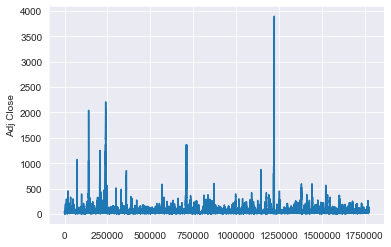

In [22]:
stockData = stockSetup2(df, "AAPL")[0]
sns.lineplot(x = df.index, y=df['Adj Close'])